## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3
from bert import CustomBert3
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train['question'] = train['question_title'] + ' [SEP] ' + train['question_body']
test['question'] = test['question_title'] + ' [SEP] ' + test['question_body']

In [4]:
init_seed()

In [5]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        for x in tqdm(df[text].values):
            encoded_inputs = tokenizer.encode_plus(
                x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
            ids.append(encoded_inputs['input_ids'])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

100%|██████████| 476/476 [00:01<00:00, 469.19it/s]


CPU times: user 26.3 s, sys: 152 ms, total: 26.5 s
Wall time: 26.8 s


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y = train[TARGETS].values.astype(np.float32)

In [9]:
num_workers = 10
bs = 2

In [10]:
bs_test = 2
test_loader = DataLoader(
    TextDataset3(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [11]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 6
grad_accum = 16
weight_decay = 0.01
model_name = 'distil_bert_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Wed Dec 18 23:17:55 2019


  0%|          | 0/1600 [00:00<?, ?it/s]/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 37%|███▋      | 592/1600 [00:59<01:55,  8.76it/s]

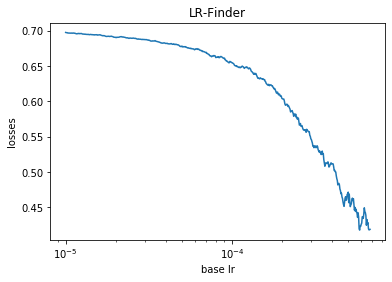

Starting inference for model: checkpoints/distil_bert_2_fold_1_best.pth



Starting inference for model: checkpoints/distil_bert_2_fold_1_best.pth



Fold 2 started at Wed Dec 18 23:19:34 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.48295 - spearmanr 0.10844
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.39679 - spearmanr 0.29923
best model: epoch 0 - 0.29923
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.38232 - spearmanr 0.32533
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.37001 - spearmanr 0.3851
best model: epoch 1 - 0.3851
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.3645 - spearmanr 0.39354
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36458 - spearmanr 0.40078
best model: epoch 2 - 0.40078
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35409 - spearmanr 0.43299
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.3625 - spearmanr 0.40809
best model: epoch 3 - 0.40809
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34575 - spearmanr 0.46383
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36275 - spearmanr 0.40979
best model: epoch 4 - 0.40979
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.34069 - spearmanr 0.48388
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36324 - spearmanr 0.40872
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 4 - 0.40979
Starting inference for model: checkpoints/distil_bert_2_fold_2_best.pth



Starting inference for model: checkpoints/distil_bert_2_fold_2_best.pth



Fold 3 started at Wed Dec 18 23:47:19 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.48379 - spearmanr 0.10589
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.39514 - spearmanr 0.29745
best model: epoch 0 - 0.29745
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.382 - spearmanr 0.32713
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.36986 - spearmanr 0.38693
best model: epoch 1 - 0.38693
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36384 - spearmanr 0.3944
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36515 - spearmanr 0.40349
best model: epoch 2 - 0.40349
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35373 - spearmanr 0.43496
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36289 - spearmanr 0.40799
best model: epoch 3 - 0.40799
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34547 - spearmanr 0.4638
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.3638 - spearmanr 0.41026
best model: epoch 4 - 0.41026
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.34042 - spearmanr 0.48303
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36431 - spearmanr 0.41115
best model: epoch 5 - 0.41115
TRAINING END: Best score achieved on epoch 5 - 0.41115
Starting inference for model: checkpoints/distil_bert_2_fold_3_best.pth



Starting inference for model: checkpoints/distil_bert_2_fold_3_best.pth



Fold 4 started at Thu Dec 19 00:14:17 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.48442 - spearmanr 0.098276
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.39468 - spearmanr 0.30275
best model: epoch 0 - 0.30275
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.38221 - spearmanr 0.33036
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.37082 - spearmanr 0.38768
best model: epoch 1 - 0.38768
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36478 - spearmanr 0.39426
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36244 - spearmanr 0.406
best model: epoch 2 - 0.406
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35472 - spearmanr 0.43022
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36113 - spearmanr 0.41432
best model: epoch 3 - 0.41432
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34639 - spearmanr 0.46292
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36075 - spearmanr 0.41433
best model: epoch 4 - 0.41433
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.34113 - spearmanr 0.48268
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36153 - spearmanr 0.41453
best model: epoch 5 - 0.41453
TRAINING END: Best score achieved on epoch 5 - 0.41453
Starting inference for model: checkpoints/distil_bert_2_fold_4_best.pth



Starting inference for model: checkpoints/distil_bert_2_fold_4_best.pth



Fold 5 started at Thu Dec 19 00:41:15 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.48518 - spearmanr 0.10012
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.40138 - spearmanr 0.29474


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.29474
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.38221 - spearmanr 0.32832
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.37127 - spearmanr 0.38346
best model: epoch 1 - 0.38346
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36415 - spearmanr 0.39493
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36589 - spearmanr 0.40145
best model: epoch 2 - 0.40145
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35389 - spearmanr 0.43304
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36409 - spearmanr 0.40641
best model: epoch 3 - 0.40641
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34602 - spearmanr 0.4635
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36415 - spearmanr 0.40909
best model: epoch 4 - 0.40909
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.34103 - spearmanr 0.48271
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36475 - spearmanr 0.40874
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 4 - 0.40909
Starting inference for model: checkpoints/distil_bert_2_fold_5_best.pth



Starting inference for model: checkpoints/distil_bert_2_fold_5_best.pth



OOF score: 0.4097120843929805


In [13]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
        
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=2)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 1: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4119#0.4097


In [14]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [15]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.930254,0.690240,0.196487,0.428754,0.723958,0.604924,0.679268,0.649831,0.742754,0.001992,0.583045,0.614807,0.012010,0.113560,0.005429,0.014076,0.117402,0.154426,0.769043,0.001321,0.917409,0.902942,0.528265,0.947880,0.958673,0.790196,0.008376,0.033876,0.872342,0.903204
1,46,0.870506,0.468900,0.002317,0.729256,0.760439,0.932352,0.546560,0.468862,0.021267,0.004088,0.490843,0.271744,0.001816,0.000309,0.000191,0.002905,0.929244,0.173981,0.058154,0.000151,0.599492,0.960714,0.663911,0.982335,0.990880,0.896581,0.969965,0.094752,0.022653,0.912471
2,70,0.900121,0.634372,0.006839,0.821334,0.931168,0.975771,0.592270,0.492331,0.191103,0.001679,0.136863,0.816340,0.007524,0.017836,0.004066,0.007474,0.070963,0.050814,0.641354,0.000817,0.808144,0.942635,0.602385,0.974684,0.977089,0.861329,0.018600,0.042049,0.913863,0.891292
3,132,0.868102,0.398543,0.002721,0.695586,0.774804,0.926668,0.524207,0.408489,0.176028,0.004715,0.502147,0.103622,0.002093,0.001567,0.000660,0.003807,0.801374,0.196035,0.536194,0.000283,0.702257,0.945273,0.689963,0.967224,0.982990,0.890232,0.820517,0.166921,0.631770,0.885903
4,200,0.913595,0.454216,0.014326,0.874418,0.856467,0.940197,0.643027,0.624351,0.075292,0.016896,0.243936,0.221896,0.008373,0.012452,0.004142,0.032839,0.167710,0.108117,0.615301,0.002594,0.651994,0.900718,0.671648,0.959943,0.956234,0.835487,0.165118,0.109858,0.629782,0.892411
